In [ ]:
# for quantify the substrate

In [1]:
%cd ~/REVIVAL2
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

/disk2/fli/REVIVAL2


In [5]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, DataStructs

from REVIVAL.global_param import LIB_INFO_DICT

In [89]:

# List of SMILES strings
smiles_list = [
    "C12=C(C=CN2)C=CC=C1",  # indoel
] + [v["substrate-smiles"] for v in LIB_INFO_DICT.values()]

name_list = ["indoel"] + [v["substrate"] for v in LIB_INFO_DICT.values()]

# Convert SMILES strings to RDKit molecule objects
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Use the new MorganGenerator to create a fingerprint generator
morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2)

# Generate fingerprints using the MorganGenerator
fingerprints = [morgan_generator.GetFingerprint(mol) for mol in molecules]


# Function to calculate Tanimoto similarity between two fingerprints
def calculate_tanimoto(fp1, fp2):
    return DataStructs.FingerprintSimilarity(fp1, fp2)

# Calculate pairwise similarity
num_molecules = len(fingerprints)
similarity_matrix = [[0] * num_molecules for _ in range(num_molecules)]

for i in range(num_molecules):
    for j in range(i, num_molecules):
        similarity = calculate_tanimoto(fingerprints[i], fingerprints[j])
        similarity_matrix[i][j] = similarity
        similarity_matrix[j][i] = similarity  # Symmetric matrix


In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

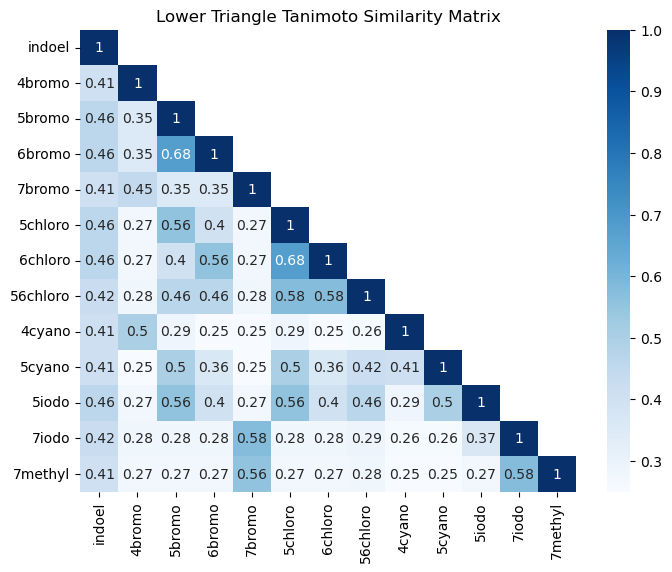

In [91]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool), k=1)

# Plot heatmap of the lower triangle (including diagonal)
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, mask=mask, cmap='Blues', xticklabels=name_list, yticklabels=name_list)
plt.title("Lower Triangle Tanimoto Similarity Matrix")
plt.show()

In [46]:
import os
from glob import glob
import pandas as pd
from scipy.stats import spearmanr

from REVIVAL.util import get_file_name

In [47]:
# loop all datasets to get spearmanr between esm_score and fitness
datasets = glob("/disk2/fli/REVIVAL2/zs/comb/*.csv")

zs_sum_df = pd.DataFrame(columns=["substrate", "ev_rho", "esm_rho", "esmif_rho"])
# get substrate name 
for d in datasets:
    substrate = get_file_name(d).split("_")[-1]
    df = pd.read_csv(d)
    print(substrate, spearmanr(df["ev_score"], df["fitness"]))
    print(substrate, spearmanr(df["esm_score"], df["fitness"]))
    print(substrate, spearmanr(df["esmif_score"], df["fitness"]))
    zs_sum_df = zs_sum_df._append(
        {
            "substrate": substrate.replace("PfTrpB-", ""),
            "ev_rho": spearmanr(df["ev_score"], df["fitness"])[0],
            "esm_rho": spearmanr(df["esm_score"], df["fitness"])[0],
            "esmif_rho": spearmanr(df["esmif_score"], df["fitness"])[0],
        },
        ignore_index=True,
    )

PfTrpB-5iodo SignificanceResult(statistic=0.4192957740759612, pvalue=1.114358220047682e-11)
PfTrpB-5iodo SignificanceResult(statistic=0.47793606097877445, pvalue=3.705607379642607e-15)
PfTrpB-5iodo SignificanceResult(statistic=0.4656249926325063, pvalue=2.266271569460718e-14)
PfTrpB-5bromo SignificanceResult(statistic=0.4874231178194408, pvalue=8.727812239020672e-16)
PfTrpB-5bromo SignificanceResult(statistic=0.5205970996328189, pvalue=3.8502203886532475e-18)
PfTrpB-5bromo SignificanceResult(statistic=0.5047066327516625, pvalue=5.567879530086214e-17)
PfTrpB-5cyano SignificanceResult(statistic=0.3964760183004303, pvalue=1.6958517224931858e-10)
PfTrpB-5cyano SignificanceResult(statistic=0.4229672533240057, pvalue=7.052019412281449e-12)
PfTrpB-5cyano SignificanceResult(statistic=0.44616416025010114, pvalue=3.4344573690520244e-13)
PfTrpB-56chloro SignificanceResult(statistic=0.38833729161751324, pvalue=4.2637858802096827e-10)
PfTrpB-56chloro SignificanceResult(statistic=0.45812831109402596

/tmp/ipykernel_3491305/1469771934.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zs_sum_df = zs_sum_df._append(


In [48]:
zs_sum_df

,substrate,ev_rho,esm_rho,esmif_rho
0,5iodo,0.419296,0.477936,0.465625
1,5bromo,0.487423,0.520597,0.504707
2,5cyano,0.396476,0.422967,0.446164
3,56chloro,0.388337,0.458128,0.441686
4,6chloro,0.569694,0.612165,0.599645
5,4cyano,0.329215,0.351774,0.372780
6,4bromo,0.474594,0.477736,0.523394
7,7iodo,0.493195,0.547916,0.568536
8,7methyl,0.498362,0.560774,0.530903
9,7bromo,0.539337,0.610038,0.516013


In [49]:
sm_df = pd.DataFrame(similarity_matrix[0], columns=["similarity"], index=name_list).reset_index().rename(columns={"index": "substrate"})
# similarity_matrix[0]
sm_df

,substrate,similarity
0,indoel,1.000000
1,4bromo,0.244444
2,5bromo,0.325581
3,6bromo,0.325581
4,7bromo,0.239130
5,5chloro,0.325581
6,6chloro,0.325581
7,56chloro,0.295455
8,4cyano,0.244898
9,5cyano,0.291667


In [50]:
merge_df = pd.merge(zs_sum_df, sm_df, on="substrate", how = "inner")
merge_df

,substrate,ev_rho,esm_rho,esmif_rho,similarity
0,5iodo,0.419296,0.477936,0.465625,0.325581
1,5bromo,0.487423,0.520597,0.504707,0.325581
2,5cyano,0.396476,0.422967,0.446164,0.291667
3,56chloro,0.388337,0.458128,0.441686,0.295455
4,6chloro,0.569694,0.612165,0.599645,0.325581
5,4cyano,0.329215,0.351774,0.372780,0.244898
6,4bromo,0.474594,0.477736,0.523394,0.244444
7,7iodo,0.493195,0.547916,0.568536,0.244444
8,7methyl,0.498362,0.560774,0.530903,0.239130
9,7bromo,0.539337,0.610038,0.516013,0.239130


In [55]:
import colorcet as cc
import matplotlib.colors as mcolors

# Select a colorcet colormap, for example, 'fire' or 'CET_CBL1'
colormap = cc.cm['glasbey_category10']

# Extract a list of hex codes from the colormap
glasbey_category10 = [mcolors.to_hex(colormap(i)) for i in range(colormap.N)]


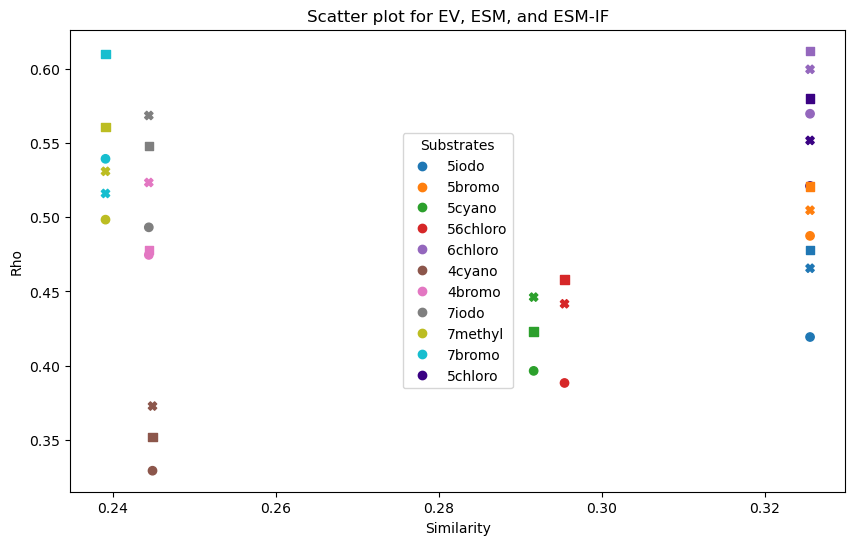

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set colors for each substrate
substrate_to_color = {substrate: color for substrate, color in zip(merge_df['substrate'].unique(), glasbey_category10[:len(merge_df)])}

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for ev_rho
plt.scatter(merge_df['similarity'], merge_df['ev_rho'], label='EV', c=merge_df['substrate'].map(substrate_to_color), marker='o')

# Scatter plot for esm_rho
plt.scatter(merge_df['similarity'], merge_df['esm_rho'], label='ESM', c=merge_df['substrate'].map(substrate_to_color), marker='s')

# Scatter plot for esmif_rho
plt.scatter(merge_df['similarity'], merge_df['esmif_rho'], label='ESM-IF', c=merge_df['substrate'].map(substrate_to_color), marker='X')

# Label and legend
plt.xlabel('Similarity')
plt.ylabel('Rho')

# Create a list of patches (legend handles)
handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='None', label=substrate)
           for substrate, color in substrate_to_color.items()]

# Create legend with the handles
legend = ax.legend(handles=handles, loc='center', title='Substrates')

# Remove the axis for a clean legend
# Create a legend with the substrates and their corresponding colors
# plt.legend(title='Substrate', loc='upper left', bbox_to_anchor=(1, 1))

plt.title('Scatter plot for EV, ESM, and ESM-IF')

plt.show()

In [80]:
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator, GetAtomPairGenerator

# Example SMILES strings
smiles_list = [
    "C12=C(C=CN2)C=CC=C1",  # indoel
] + [v["substrate-smiles"] for v in LIB_INFO_DICT.values()]

name_list = ["indoel"] + [v["substrate"] for v in LIB_INFO_DICT.values()]

# Convert SMILES to RDKit molecule objects
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Initialize fingerprint generators
morgan_gen = GetMorganGenerator(radius=2)  # Morgan (circular) fingerprint generator
atom_pair_gen = GetAtomPairGenerator()     # Atom-Pair fingerprint generator

# Function to compute Morgan Fingerprint
def compute_morgan_fingerprint(mol):
    return morgan_gen.GetFingerprint(mol)

# Function to compute MACCS keys
def compute_maccs_fingerprint(mol):
    return MACCSkeys.GenMACCSKeys(mol)

# Function to compute Atom-Pair Fingerprints
def compute_atom_pair_fingerprint(mol):
    return atom_pair_gen.GetFingerprint(mol)

# Compute fingerprints for each molecule
morgan_fps = [compute_morgan_fingerprint(mol) for mol in mols]
maccs_fps = [compute_maccs_fingerprint(mol) for mol in mols]
atom_pair_fps = [compute_atom_pair_fingerprint(mol) for mol in mols]

# Calculate pairwise similarity
num_molecules = len(morgan_fps)
morgan_matrix = [[0] * num_molecules for _ in range(num_molecules)]
maccs_matrix = [[0] * num_molecules for _ in range(num_molecules)]
atom_pair_matrix = [[0] * num_molecules for _ in range(num_molecules)]

# Compute similarity (Tanimoto) between molecules using Morgan fingerprints
for i in range(len(mols)):
    for j in range(i, len(mols)):
        morgan_matrix[i][j] = DataStructs.FingerprintSimilarity(morgan_fps[i], morgan_fps[j])
        morgan_matrix[j][i] = DataStructs.FingerprintSimilarity(morgan_fps[i], morgan_fps[j])

        maccs_matrix[i][j] = DataStructs.FingerprintSimilarity(maccs_fps[i], maccs_fps[j])
        maccs_matrix[j][i] = DataStructs.FingerprintSimilarity(maccs_fps[i], maccs_fps[j])

        atom_pair_matrix[i][j] = DataStructs.FingerprintSimilarity(atom_pair_fps[i], atom_pair_fps[j])
        atom_pair_matrix[j][i] = DataStructs.FingerprintSimilarity(atom_pair_fps[i], atom_pair_fps[j])

        # print(f"Morgan similarity between {smiles_list[i]} and {smiles_list[j]}: {similarity:.2f}")

# Compute Maximum Common Substructure (MCS)
# mcs = FindMCS(mols)
# mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
# mcs_smiles = Chem.MolToSmiles(mcs_mol)

# print(f"Maximum Common Substructure (MCS): {mcs_smiles}")


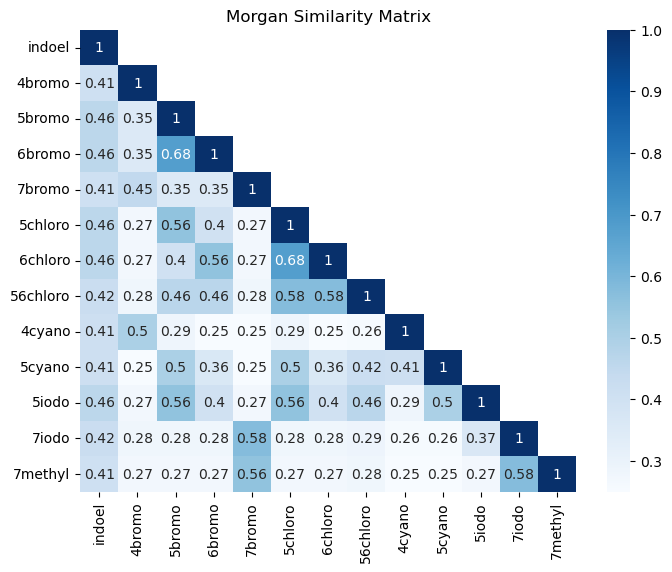

In [83]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(morgan_matrix, dtype=bool), k=1)

# Plot heatmap of the lower triangle (including diagonal)
plt.figure(figsize=(8, 6))
sns.heatmap(morgan_matrix, annot=True, mask=mask, cmap='Blues', xticklabels=name_list, yticklabels=name_list)
plt.title("Morgan Similarity Matrix")
plt.show()

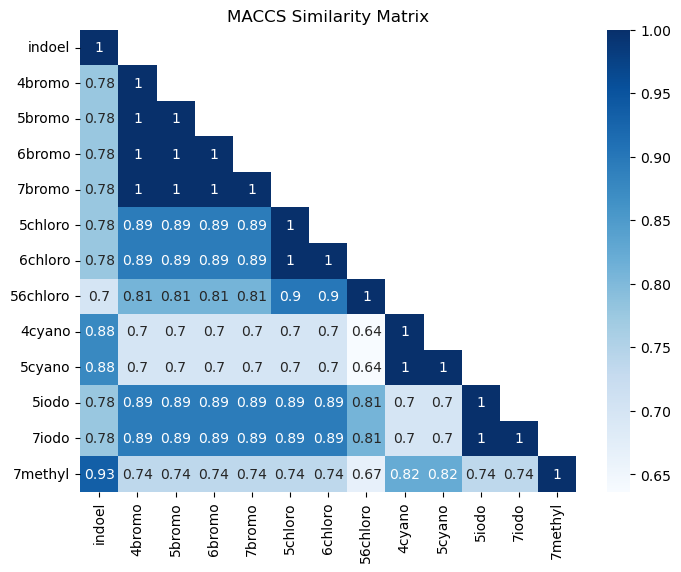

In [84]:
plt.figure(figsize=(8, 6))
sns.heatmap(maccs_matrix, annot=True, mask=mask, cmap='Blues', xticklabels=name_list, yticklabels=name_list)
plt.title("MACCS Similarity Matrix")
plt.show()

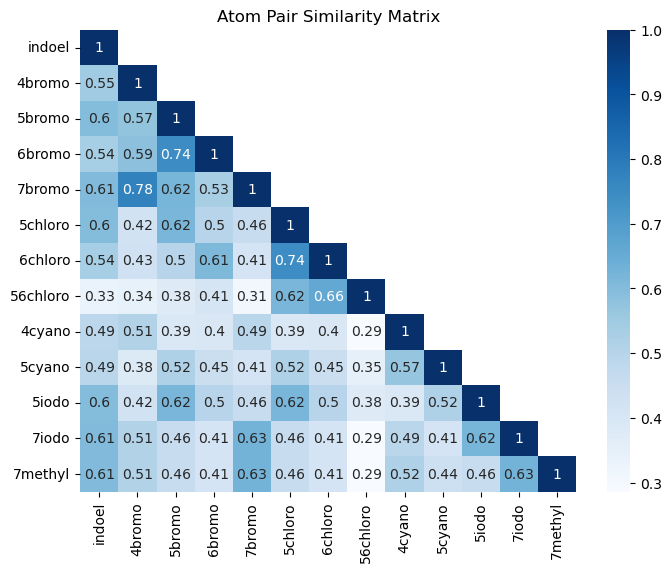

In [88]:
plt.figure(figsize=(8, 6))
sns.heatmap(atom_pair_matrix, annot=True, mask=mask, cmap='Blues', xticklabels=name_list, yticklabels=name_list)
plt.title("Atom Pair Similarity Matrix")
plt.show()

In [94]:
sm_df = pd.DataFrame({"substrate": name_list, "morgan": morgan_matrix[0], "MACCS": maccs_matrix[0], "Atom Pair": atom_pair_matrix[0]})
# similarity_matrix[0]
sm_df

,substrate,morgan,MACCS,Atom Pair
0,indoel,1.000000,1.000000,1.000000
1,4bromo,0.407407,0.777778,0.550000
2,5bromo,0.461538,0.777778,0.600000
3,6bromo,0.461538,0.777778,0.536585
4,7bromo,0.407407,0.777778,0.605263
5,5chloro,0.461538,0.777778,0.600000
6,6chloro,0.461538,0.777778,0.536585
7,56chloro,0.423077,0.700000,0.333333
8,4cyano,0.413793,0.875000,0.489362
9,5cyano,0.413793,0.875000,0.489796


In [95]:
merge_df = pd.merge(zs_sum_df, sm_df, on="substrate", how = "inner")
merge_df

,substrate,ev_rho,esm_rho,esmif_rho,morgan,MACCS,Atom Pair
0,5iodo,0.419296,0.477936,0.465625,0.461538,0.777778,0.600000
1,5bromo,0.487423,0.520597,0.504707,0.461538,0.777778,0.600000
2,5cyano,0.396476,0.422967,0.446164,0.413793,0.875000,0.489796
3,56chloro,0.388337,0.458128,0.441686,0.423077,0.700000,0.333333
4,6chloro,0.569694,0.612165,0.599645,0.461538,0.777778,0.536585
5,4cyano,0.329215,0.351774,0.372780,0.413793,0.875000,0.489362
6,4bromo,0.474594,0.477736,0.523394,0.407407,0.777778,0.550000
7,7iodo,0.493195,0.547916,0.568536,0.423077,0.777778,0.605263
8,7methyl,0.498362,0.560774,0.530903,0.407407,0.933333,0.605263
9,7bromo,0.539337,0.610038,0.516013,0.407407,0.777778,0.605263


In [97]:
spearmanr(merge_df["morgan"], merge_df["ev_rho"]), spearmanr(merge_df["morgan"], merge_df["esm_rho"]), spearmanr(merge_df["morgan"], merge_df["esmif_rho"])

(SignificanceResult(statistic=0.10856789360709565, pvalue=0.7506765512115972),
 SignificanceResult(statistic=0.19825441441295727, pvalue=0.5589729148441118),
 SignificanceResult(statistic=0.16521201201079772, pvalue=0.6273523256541317))

In [98]:
spearmanr(merge_df["MACCS"], merge_df["ev_rho"]), spearmanr(merge_df["MACCS"], merge_df["esm_rho"]), spearmanr(merge_df["MACCS"], merge_df["esmif_rho"])

(SignificanceResult(statistic=-0.08449185402476447, pvalue=0.804914892145733),
 SignificanceResult(statistic=-0.17426444892607673, pvalue=0.608326588624466),
 SignificanceResult(statistic=-0.08449185402476447, pvalue=0.804914892145733))

In [99]:
spearmanr(merge_df["Atom Pair"], merge_df["ev_rho"]), spearmanr(merge_df["Atom Pair"], merge_df["esm_rho"]), spearmanr(merge_df["Atom Pair"], merge_df["esmif_rho"])

(SignificanceResult(statistic=0.6389984659223487, pvalue=0.03429979411805274),
 SignificanceResult(statistic=0.6389984659223487, pvalue=0.03429979411805274),
 SignificanceResult(statistic=0.574172534596893, pvalue=0.06470966019157458))